# Catchment and river network delineation
Plots the shapefiles provided for use in SUMMA and mizuRoute setup side by side.

In [1]:
import pyproj
import numpy as np
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Define where to save the figure

In [25]:
# Path and filename
fig_path = read_from_control(controlFolder/controlFile,'visualization_folder')
fig_name = 'spatial_delineation_mizuRoute_summa_v2.png'

# Specify default path if needed
if fig_path == 'default':
    fig_path = make_default_path('visualization') # outputs a Path()
else:
    fig_path = Path(fig_path) # make sure a user-specified path is a Path()
    
# Make the folder if it doesn't exist
fig_path.mkdir(parents=True, exist_ok=True)

#### Get shapefile location from control file

In [13]:
# HM catchment shapefile path & name
hm_catchment_path = read_from_control(controlFolder/controlFile,'catchment_shp_path')
hm_catchment_name = read_from_control(controlFolder/controlFile,'catchment_shp_name')

# Specify default path if needed
if hm_catchment_path == 'default':
    hm_catchment_path = make_default_path('shapefiles/catchment') # outputs a Path()
else:
    hm_catchment_path = Path(hm_catchment_path) # make sure a user-specified path is a Path()

In [14]:
# Routing model catchment shapefile path & name
rm_catchment_path = read_from_control(controlFolder/controlFile,'river_basin_shp_path')
rm_catchment_name = read_from_control(controlFolder/controlFile,'river_basin_shp_name')

# Specify default path if needed
if rm_catchment_path == 'default':
    rm_catchment_path = make_default_path('shapefiles/river_basins') # outputs a Path()
else:
    rm_catchment_path = Path(rm_catchment_path) # make sure a user-specified path is a Path()

In [15]:
# River network shapefile path & name
rm_river_path = read_from_control(controlFolder/controlFile,'river_network_shp_path')
rm_river_name = read_from_control(controlFolder/controlFile,'river_network_shp_name')

# Specify default path if needed
if rm_river_path == 'default':
    rm_river_path = make_default_path('shapefiles/river_network') # outputs a Path()
else:
    rm_river_path = Path(rm_river_path) # make sure a user-specified path is a Path()

#### Load the data

In [16]:
hm_catchment = gpd.read_file(hm_catchment_path/hm_catchment_name)
rm_catchment = gpd.read_file(rm_catchment_path/rm_catchment_name)
rm_river = gpd.read_file(rm_river_path/rm_river_name)

#### Reproject to equal area if desired
Note: not great for Bow at Banff because it stretches things in an awkward way. Results are easier to see in regular lat/lon.

In [18]:
# Define the target CRS (North America Albers Equal Area Conic)
crs = pyproj.CRS.from_proj4("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m no_defs")

In [15]:
# remap
hm_catchment = hm_catchment.to_crs(crs)
rm_catchment = rm_catchment.to_crs(crs)
rm_river = rm_river.to_crs(crs)

#### Create a shapefile with GRU boundaries only (SUMMA)

In [18]:
# Find the GRU identifier
hm_gruid = read_from_control(controlFolder/controlFile,'catchment_shp_gruid')

In [19]:
# Select the columns we're after
hm_grus_only = hm_catchment[[hm_gruid,'geometry']]

In [20]:
# Dissolve HRU delineation
hm_grus_only = hm_grus_only.dissolve(by=hm_gruid)

#### Figure

In [21]:
# Create a distinct colormap for river segments
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

n_river = len(rm_river) # number of reaches
cm_river = get_cmap(n_river) # get the colormap
col_river = cm_river(range(0,n_river)) # convert to array
np.random.shuffle(col_river)

In [27]:
plt.rcParams.update({'font.size': 12})

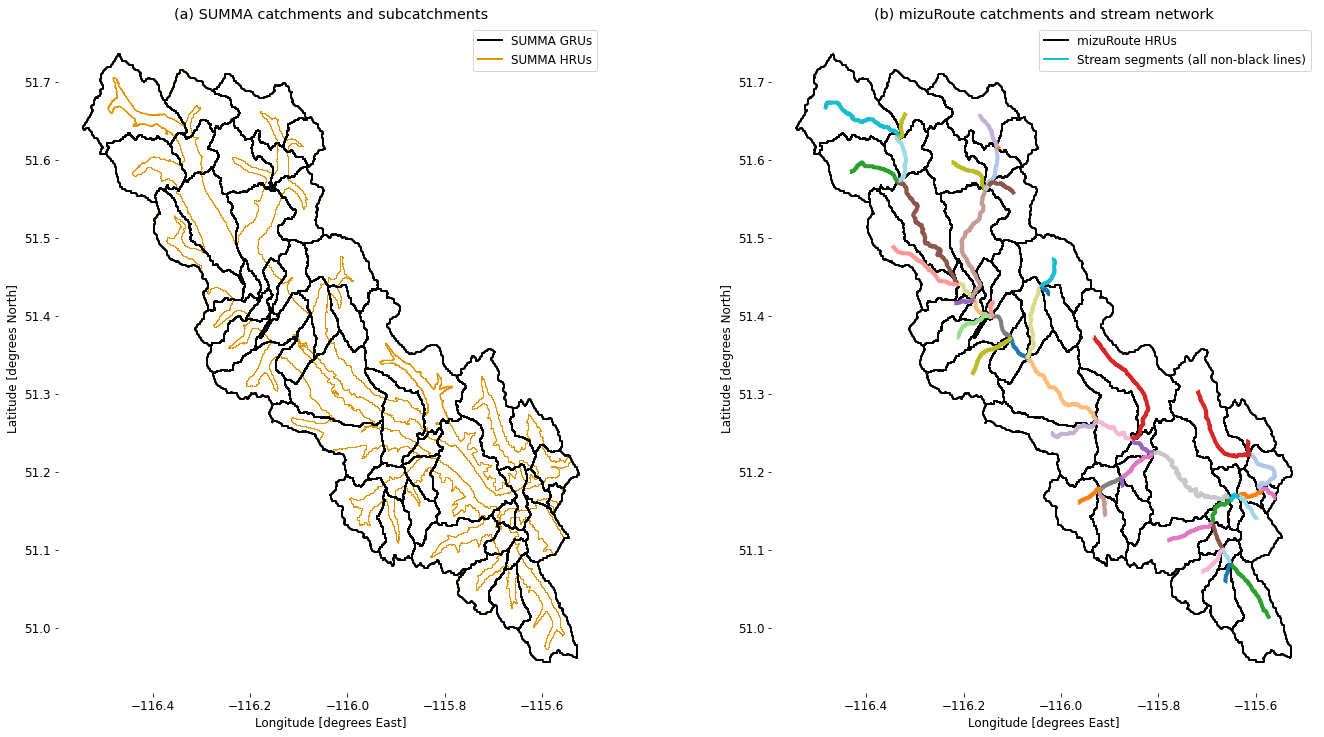

In [29]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
plt.tight_layout()
plt.rcParams.update({'font.size': 12})

# --- mizuRoute
axId = 1
rm_catchment.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2)
rm_river.plot(ax=axs[axId],color=col_river,linewidth=4)

# custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color=col_river[1], lw=2)]
label = ['mizuRoute HRUs',
         'Stream segments (all non-black lines)']
axs[axId].legend(lines,label);

# title
axs[axId].set_title('(b) mizuRoute catchments and stream network');
axs[axId].set_frame_on(False)
axs[axId].set_xlabel('Longitude [degrees East]');
axs[axId].set_ylabel('Latitude [degrees North]');

# --- summa
axId = 0
#hruColor = (105/256,105/256,105/256,1)
hruColor = (229/256,148/256,0/256,1)
hm_catchment.plot(ax=axs[axId],facecolor='none',edgecolor=hruColor)
hm_grus_only.plot(ax=axs[axId],facecolor='none',edgecolor='k',linewidth=2) 

# custom legend
lines = [Line2D([0], [0], color='k', lw=2),
         Line2D([0], [0], color=hruColor, lw=2)]
label = ['SUMMA GRUs',
         'SUMMA HRUs']
axs[axId].legend(lines,label);

# title
axs[axId].set_title('(a) SUMMA catchments and subcatchments');
axs[axId].set_frame_on(False)
axs[axId].set_xlabel('Longitude [degrees East]');
axs[axId].set_ylabel('Latitude [degrees North]');

# save
plt.savefig(fig_path/fig_name, bbox_inches='tight', dpi=300)